In [1]:
# Minimal Reproducable Example to check errors
import numpy as np
import h5py
import hdf5plugin
import matplotlib.pyplot as plt

In [2]:
def mass_function(mass, volume, bins, range=None, poisson_uncert=False,
                  return_edges=False, **kwargs):

    if "normed" in kwargs:
        kwargs["normed"] = False
        log.warn("Turned off normed kwarg in mass_function()")

    if (range is not None and (bins in ['blocks',
                                        'knuth', 'knuths',
                                        'scott', 'scotts',
                                        'freedman', 'freedmans'])):
        mass = mass[(mass >= range[0]) & (mass <= range[1])]

    if isinstance(bins, str):
        log.info("Calculating bin widths using `%s' method..." % bins)
        if bins in ['blocks']:
            bins = bayesian_blocks(mass)
        elif bins in ['knuth', 'knuths']:
            dm, bins = knuth_bin_width(mass, True)
        elif bins in ['scott', 'scotts']:
            dm, bins = scotts_bin_width(mass, True)
        elif bins in ['freedman', 'freedmans']:
            dm, bins = freedman_bin_width(mass, True)
        else:
            raise ValueError("unrecognized bin code: '%s'" % bins)
        log.info("...done")

    vals, edges = np.histogram(mass, bins, range, **kwargs)
    width = edges[1]-edges[0]
    radius = width/2.0
    centers = edges[:-1]+radius
    if poisson_uncert:
        uncert = np.sqrt(vals.astype(float))

    vals = vals.astype(float) / (volume * width)

    if not poisson_uncert:
        mf = np.dstack((centers, vals)).squeeze()
    else:
        uncert /= (volume * width)
        mf = np.dstack((centers, vals, uncert)).squeeze()

    if not return_edges:
        return mf
    else:
        return mf, edges

In [3]:
## CV_0/snap_026.hdf5
# Need to use PartType4 Masses for STELLAR Mass, not Halo mass
snap_stars  = '/home/jovyan/Data/Sims/IllustrisTNG/CV/CV_0/snap_026.hdf5'
data = h5py.File(snap_stars, 'r')
BoxSize      = data['Header'].attrs[u'BoxSize']/1e3    #size of the snapshot in comoving Mpc/h
redshift     = data['Header'].attrs[u'Redshift']       #reshift of the snapshot
print('Box size:                 %.2f Mpc/h'%BoxSize)
print('snapshot redshift:        %.2f'%redshift)

Box size:                 25.00 Mpc/h
snapshot redshift:        0.40


In [4]:
## GALAXIES IN HALOES SO NEED GALAXY STELLAR MASS
# get the name of Subfind halo catalog
subhalos  = '/home/jovyan/Data/FOF_Subfind/IllustrisTNG/CV/CV_0/fof_subhalo_tab_026.hdf5'
# read halo catalogue
subh = h5py.File(subhalos, 'r')
subh.keys()

<KeysViewHDF5 ['Config', 'Group', 'Header', 'IDs', 'Parameters', 'Subhalo']>

In [5]:
subh['Subhalo'].keys()

<KeysViewHDF5 ['SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHalfRad', 'SubhaloGasMetallicityMaxRad', 'SubhaloGasMetallicitySfr', 'SubhaloGasMetallicitySfrWeighted', 'SubhaloGrNr', 'SubhaloHalfmassRad', 'SubhaloHalfmassRadType', 'SubhaloIDMostbound', 'SubhaloLen', 'SubhaloLenType', 'SubhaloMass', 'SubhaloMassInHalfRad', 'SubhaloMassInHalfRadType', 'SubhaloMassInMaxRad', 'SubhaloMassInMaxRadType', 'SubhaloMassInRad', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloSFR', 'SubhaloSFRinHalfRad', 'SubhaloSFRinMaxRad', 'SubhaloSFRinRad', 'SubhaloSpin', 'SubhaloStarMetalFractions', 'SubhaloStarMetalFractionsHalfRad', 'SubhaloStarMetalFractionsMaxRad', 'SubhaloStarMetallicity', 'SubhaloStarMetallicityHalfRad', '

In [6]:
# the mass of all star particles associated with a subhalo, is given by SubhaloMassType
mass_sol = subh['Subhalo/SubhaloMassType'][:] # in 1e10𝑀⊙/ℎ
mass_sol

array([[4.58408356e+02, 3.71254077e+03, 0.00000000e+00, 0.00000000e+00,
        3.32005348e+01, 2.27090687e-01],
       [1.55289415e-02, 1.25998182e+01, 0.00000000e+00, 0.00000000e+00,
        7.13820601e+00, 5.18528186e-02],
       [2.13028240e+00, 3.20769806e+01, 0.00000000e+00, 0.00000000e+00,
        1.49825788e+00, 7.66853802e-03],
       ...,
       [0.00000000e+00, 1.62201568e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.62201568e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.68689638e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]], dtype=float32)

In [7]:
# remove 0 values
mass_sol_nonzero = mass_sol[mass_sol > 0]

In [8]:
mass_sol = np.log(mass_sol_nonzero*1e10)
mass_sol

array([29.153612, 31.245323, 26.528418, ..., 21.206936, 21.206936,
       21.246157], dtype=float32)

In [9]:
# Plotting the volume normalised number of galaxies in bins of stellar mass

V = BoxSize**3 
print('Volume %.2f Mpc^3'%V)

smf = mass_function(mass_sol_nonzero,V, bins=50,range=None)
print('SMF',smf)

Volume 15625.00 Mpc^3
SMF [[3.71255836e+01 2.68710850e-02]
 [1.11376404e+02 3.01680185e-05]
 [1.85627213e+02 7.75749047e-06]
 [2.59878021e+02 6.89554708e-06]
 [3.34128815e+02 3.44777354e-06]
 [4.08379639e+02 3.44777354e-06]
 [4.82630432e+02 2.58583016e-06]
 [5.56881287e+02 1.72388677e-06]
 [6.31132080e+02 0.00000000e+00]
 [7.05382935e+02 0.00000000e+00]
 [7.79633728e+02 8.61943385e-07]
 [8.53884521e+02 8.61943385e-07]
 [9.28135376e+02 0.00000000e+00]
 [1.00238617e+03 8.61943385e-07]
 [1.07663696e+03 0.00000000e+00]
 [1.15088770e+03 0.00000000e+00]
 [1.22513855e+03 1.72388677e-06]
 [1.29938940e+03 0.00000000e+00]
 [1.37364014e+03 0.00000000e+00]
 [1.44789099e+03 0.00000000e+00]
 [1.52214172e+03 8.61943385e-07]
 [1.59639258e+03 0.00000000e+00]
 [1.67064343e+03 0.00000000e+00]
 [1.74489417e+03 0.00000000e+00]
 [1.81914502e+03 0.00000000e+00]
 [1.89339587e+03 0.00000000e+00]
 [1.96764661e+03 0.00000000e+00]
 [2.04189746e+03 0.00000000e+00]
 [2.11614844e+03 0.00000000e+00]
 [2.19039917e+03 

In [10]:
# Filter out zero values from the SMF array
smf_nonzero = smf[smf[:, 1] != 0.0]
smf_nonzero


array([[3.71255836e+01, 2.68710850e-02],
       [1.11376404e+02, 3.01680185e-05],
       [1.85627213e+02, 7.75749047e-06],
       [2.59878021e+02, 6.89554708e-06],
       [3.34128815e+02, 3.44777354e-06],
       [4.08379639e+02, 3.44777354e-06],
       [4.82630432e+02, 2.58583016e-06],
       [5.56881287e+02, 1.72388677e-06],
       [7.79633728e+02, 8.61943385e-07],
       [8.53884521e+02, 8.61943385e-07],
       [1.00238617e+03, 8.61943385e-07],
       [1.22513855e+03, 1.72388677e-06],
       [1.52214172e+03, 8.61943385e-07],
       [3.67541553e+03, 8.61943385e-07]])


smf_normalized = smf_nonzero[:, 1] / V
smf_normalized

/tmp/ipykernel_4178/1255450415.py:8: RuntimeWarning: divide by zero encountered in log
  y = np.log(smf[:,1])
/tmp/ipykernel_4178/1255450415.py:20: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')  # Apply logarithmic scale to the y-axis as well


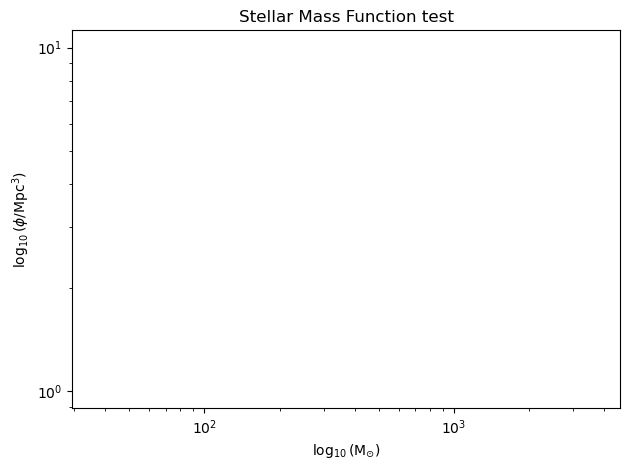

In [11]:
#print(plot_number)
fig, ax = plt.subplots(1, 1)
plt.title("Stellar Mass Function test")
plot_label = ('Stellar mass in $M_{\odot}$')

# x,y
x = smf[:,0]
y = np.log(smf[:,1])

ax.plot(x,y, color=np.random.rand(3,), lw=2,
            label=plot_label)

# Set the axis labels.
# Note the use of LaTeX here.
ax.set_xlabel(r"$\log_{10}({\rm M_{\odot}})$")
ax.set_ylabel(r"$\log_{10}(\phi / {\rm Mpc^3})$")

# Apply logarithmic scale to both x and y axes
ax.set_xscale('log')
ax.set_yscale('log')  # Apply logarithmic scale to the y-axis as well

# Add the legend
#ax.legend(loc="upper right")

# Finally save the figure as a PDF
plt.tight_layout()